## Find similar stars

Because a simple differential photometry doesn't work well we need to find a suitable set of reference stars that undergo the same changes (e.g. airmass, cloud cover, etc) as our target star.

Ultimately we are concerned about how the flux of our target changes with respect to a suitable set of reference stars and therefore we need to be careful **not** to use flux as a selection parameter for determining the "best" reference stars. That is, we **do not** want to choose reference stars that undergo a reduction of flux in the middle of the observation as this will hide the transit signal in our target.

We can marginalize across the flux by normalizing each stamp to the total flux in the stamp (see [Normalize](Algorithm.ipynb#normalize) in algorithm description). By doing so we are effectively looking at the shape of the star as it appears on the RGB pixel pattern. This morphology will change slightly from frame to frame so we want to look for reference stars that change similarly to our target star with respect to this morphology.

By taking the summed squared difference (SSD) between each pixel of the normalized target and reference star we can get a single metric that defines how well the reference star matches the target. Because the SSD is looking at the difference between the target and a reference, a lower metric value for the refernce indicates a better match with the target. The target stamp compared with itself would yield a value of zero.

We perform the SSD for each frame in the observation and take the sum of all the SSDs for each source as the final metric score to compare against our target. Again, lower scores mean that the reference is more "similar" in a morphological sense: it's shape on the RGB pattern changes similar to that of the target. See [Find Reference Stars](Algorithm.ipynb#find_reference) for details and mathematical description.

### Get the ranking for comparison stars

For each source that was identified above we want to find the most "similar" stars by ranking them according to how the shape of their PSF differs from that of the target. This is done for each frame and the sum across all frames determines the "similarity", with smaller final sums indicating stars that are similar to the target. The target ranked against itself would yield a value of zero.

By the numbers, this is doing the sum of the summed squared difference (SSD) for each pixel in the stamp for each frame. Importantly, it is doing this comparision on the normalized version of each stamp. The stamp is normalized according to the total sum of the stamp. See [Step 1](Algorithm.ipynb#normalize) below for the Normalization and [Step 2](Algorithm.ipynb#find_references) for the sum of the SSD.

In [12]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict

from matplotlib import pyplot as plt

from glob import glob
from tqdm import tqdm_notebook

In [2]:
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'

sources_noise = pd.read_csv(os.path.join(base_dir, f'point-sources-noise.csv')).set_index(['date_obs'])
sources_noise.index = pd.to_datetime(sources_noise.index)

In [3]:
picid = 256364928

In [4]:
target_table = pd.read_csv(os.path.join(base_dir, 'stamps', f'{picid}.csv')).set_index(['obs_time', 'picid'])

In [5]:
camera_bias = 2048

In [6]:
target_psc = np.array(target_table) - camera_bias

In [7]:
# Normalize target
normalized_target_psc = (target_psc.T / target_psc.sum(1)).T

In [8]:
stamp_files = glob(os.path.join(base_dir, 'stamps', '*.csv'))

In [9]:
vary = dict()
for stamp_fn in tqdm_notebook(stamp_files):
    ref_table = pd.read_csv(stamp_fn).set_index(['obs_time', 'picid'])
    ref_psc = np.array(ref_table) - camera_bias
    
    normalized_ref_psc = (ref_psc.T / ref_psc.sum(1)).T
    
    try:
        score = ((normalized_target_psc - normalized_ref_psc)**2).sum()
    except ValueError:
        continue
        
    vary[ref_table.index.levels[1][0]] = score

In [10]:
vary_series = pd.Series(vary).sort_values()

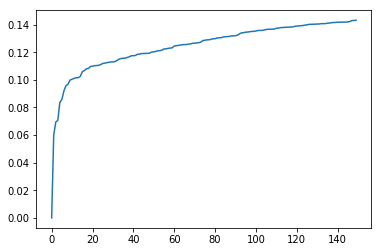

In [15]:
plt.plot(vary_series.values[:150])

In [16]:
vary_series.to_csv(os.path.join(base_dir, 'vary-{}.csv'.format(picid)))